# Laboratorio 7 Deep Learning

Laboratorio 7 – Deep Learning

Edwin Ortega 22305 - Esteban Zambrano 22119

Link del repositorio:<br>
https://github.com/EstebanZG999/Lab7_DL

### Task 1 - Práctica

In [1]:
# pip install gymnasium numpy torch matplotlib

#### Imports

In [2]:
import math
import random
import numpy as np
import collections
from dataclasses import dataclass
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym

#### Configuración y utilidades

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ENV_ID = "CartPole-v1"
env = gym.make(ENV_ID)
eval_env = gym.make(ENV_ID)

obs, _ = env.reset(seed=SEED)

n_states = env.observation_space.shape[0]    # 4
n_actions = env.action_space.n               # 2

#### Red Q

In [4]:
class QNetwork(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, hidden: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_dim),
        )

    def forward(self, x):
        return self.net(x)

#### Replay Buffer

In [5]:
Transition = collections.namedtuple(
    "Transition", ("state", "action", "reward", "next_state", "done")
)

class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)

#### Hiperparámetros

In [6]:
GAMMA = 0.99
LR = 1e-3
BATCH_SIZE = 64
BUFFER_CAPACITY = 50_000

# Exploración (epsilon-greedy)
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 10_000 

# Sincronización de red objetivo
TARGET_SYNC_EVERY = 1000  # pasos
USE_SOFT_UPDATE = False
TAU = 0.005

# Entrenamiento
MAX_EPISODES = 400
MAX_STEPS_PER_EP = 1000
RENDER_DURING_TRAIN = False  # True para visualizar

# Evaluación
EVAL_EPISODES = 5

#### Inicialización de redes y optimizador


In [7]:
policy_net = QNetwork(n_states, n_actions).to(device)
target_net = QNetwork(n_states, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
replay = ReplayBuffer(BUFFER_CAPACITY)

#### Selección de acción

In [8]:
steps_done = 0

def epsilon_by_step(step: int) -> float:
    # Exponencial suave: eps = EPS_END + (EPS_START - EPS_END) * exp(-step/decay)
    return EPS_END + (EPS_START - EPS_END) * math.exp(-step / EPS_DECAY)

def select_action(state: np.ndarray) -> int:
    global steps_done
    eps = epsilon_by_step(steps_done)
    steps_done += 1
    if random.random() < eps:
        return env.action_space.sample()
    with torch.no_grad():
        s = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q = policy_net(s)
        return int(q.argmax(dim=1).item())

#### Actualización de la red

In [9]:
mse_loss = nn.SmoothL1Loss()  # Huber loss

def optimize_model():
    if len(replay) < BATCH_SIZE:
        return None

    batch = replay.sample(BATCH_SIZE)

    state_batch = torch.as_tensor(np.array(batch.state), dtype=torch.float32, device=device)
    action_batch = torch.as_tensor(batch.action, dtype=torch.int64, device=device).unsqueeze(1)
    reward_batch = torch.as_tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
    next_state_batch = torch.as_tensor(np.array(batch.next_state), dtype=torch.float32, device=device)
    done_batch = torch.as_tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

    # Q(s,a) actual de la policy_net
    q_values = policy_net(state_batch).gather(1, action_batch)

    # Q objetivo: r + gamma * max_a' Q_target(s', a') * (1 - done)
    with torch.no_grad():
        next_q = target_net(next_state_batch).max(dim=1, keepdim=True)[0]
        target = reward_batch + (1.0 - done_batch) * GAMMA * next_q

    loss = mse_loss(q_values, target)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 10.0)
    optimizer.step()
    return float(loss.item())

def hard_update_target():
    target_net.load_state_dict(policy_net.state_dict())

def soft_update_target(tau: float):
    with torch.no_grad():
        for p, tp in zip(policy_net.parameters(), target_net.parameters()):
            tp.data.mul_(1 - tau).add_(tau * p.data)

#### Ciclo de entrenamiento

In [10]:
episode_rewards = []
episode_losses = []

global_step = 0

for ep in range(1, MAX_EPISODES + 1):
    state, _ = env.reset(seed=SEED + ep)
    ep_reward = 0.0
    ep_losses = []

    for t in range(MAX_STEPS_PER_EP):
        if RENDER_DURING_TRAIN:
            env.render()

        action = select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # shaping
        replay.push(state, action, reward, next_state, float(done))

        state = next_state
        ep_reward += reward
        global_step += 1

        loss = optimize_model()
        if loss is not None:
            ep_losses.append(loss)

        # Actualizar red objetivo
        if USE_SOFT_UPDATE:
            soft_update_target(TAU)
        else:
            if global_step % TARGET_SYNC_EVERY == 0:
                hard_update_target()

        if done:
            break

    episode_rewards.append(ep_reward)
    episode_losses.append(np.mean(ep_losses) if ep_losses else np.nan)

    if ep % 10 == 0:
        avg_last = np.mean(episode_rewards[-10:])
        print(f"[Episodio {ep:03d}] Recompensa media (últimos 10): {avg_last:.1f} | "
              f"epsilon≈{epsilon_by_step(global_step):.3f}")

# Cerrar render si se usó
env.close()

[Episodio 010] Recompensa media (últimos 10): 22.8 | epsilon≈0.979
[Episodio 020] Recompensa media (últimos 10): 17.4 | epsilon≈0.963
[Episodio 030] Recompensa media (últimos 10): 22.0 | epsilon≈0.943
[Episodio 040] Recompensa media (últimos 10): 24.7 | epsilon≈0.921
[Episodio 050] Recompensa media (últimos 10): 32.1 | epsilon≈0.893
[Episodio 060] Recompensa media (últimos 10): 24.1 | epsilon≈0.873
[Episodio 070] Recompensa media (últimos 10): 21.5 | epsilon≈0.856
[Episodio 080] Recompensa media (últimos 10): 16.9 | epsilon≈0.842
[Episodio 090] Recompensa media (últimos 10): 31.6 | epsilon≈0.818
[Episodio 100] Recompensa media (últimos 10): 27.1 | epsilon≈0.797
[Episodio 110] Recompensa media (últimos 10): 33.0 | epsilon≈0.773
[Episodio 120] Recompensa media (últimos 10): 34.9 | epsilon≈0.748
[Episodio 130] Recompensa media (últimos 10): 29.1 | epsilon≈0.728
[Episodio 140] Recompensa media (últimos 10): 30.0 | epsilon≈0.708
[Episodio 150] Recompensa media (últimos 10): 21.1 | epsilon≈0

#### Curvas de entrenamiento

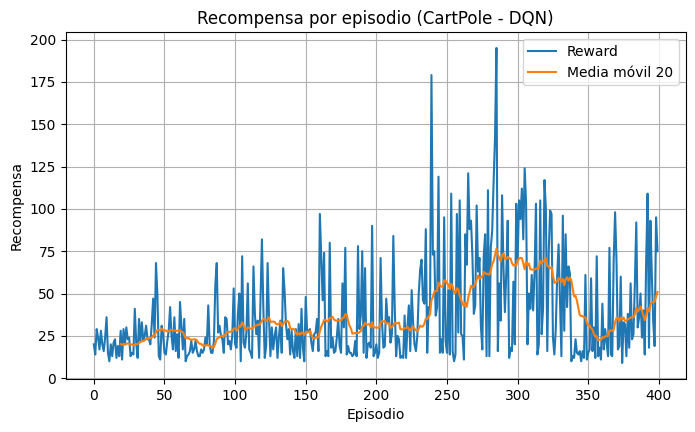

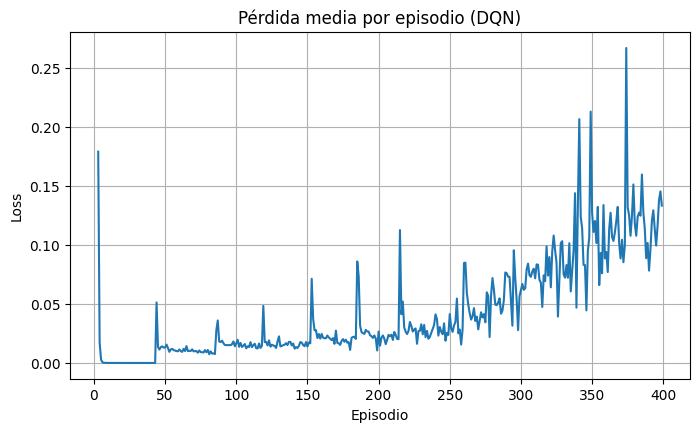

In [11]:
plt.figure(figsize=(8,4.5))
plt.title("Recompensa por episodio (CartPole - DQN)")
plt.plot(episode_rewards, label="Reward")
# Promedio móvil simple para suavizar
window = 20
if len(episode_rewards) >= window:
    mov_avg = np.convolve(episode_rewards, np.ones(window)/window, mode="valid")
    plt.plot(range(window-1, len(episode_rewards)), mov_avg, label=f"Media móvil {window}")
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4.5))
plt.title("Pérdida media por episodio (DQN)")
plt.plot(episode_losses)
plt.xlabel("Episodio")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

#### Evaluación sin exploración

In [12]:
def evaluate(agent_net: nn.Module, env_eval: gym.Env, episodes: int = 5) -> float:
    agent_net.eval()
    total = 0.0
    with torch.no_grad():
        for i in range(episodes):
            s, _ = env_eval.reset(seed=SEED + 10_000 + i)
            ep_r = 0.0
            while True:
                q = agent_net(torch.as_tensor(s, dtype=torch.float32, device=device).unsqueeze(0))
                a = int(q.argmax(dim=1).item())
                s, r, term, trunc, _ = env_eval.step(a)
                ep_r += r
                if term or trunc:
                    break
            total += ep_r
    return total / episodes

avg_eval = evaluate(policy_net, eval_env, episodes=EVAL_EPISODES)
eval_env.close()
print(f"Recompensa promedio de evaluación en {EVAL_EPISODES} episodios: {avg_eval:.1f}")

Recompensa promedio de evaluación en 5 episodios: 96.4


#### Proximal Policy Optimization (PPO)

Es un algoritmo de gradiente de política cuyo propósito es optimizar la política de un agente de manera constante. Para lograrlo, implementa una función objetivo que emplea un mecanismo de clipping; este último previene que la probabilidad de las acciones varíe demasiado entre actualizaciones consecutivas. Esto evita cambios bruscos y facilita la capacitación en entornos complejos. En los videojuegos de tipo Atari, en las simulaciones físicas (como MuJoCo) o en los trabajos robóticos, donde la estabilidad del aprendizaje es esencial, el PPO se utiliza principalmente para problemas de alta dimensionalidad, ya sean acciones continuas o discretas.

#### Deep Deterministic Policy Gradient (DDPG)

Es un algoritmo actor-crítico diseñado con el propósito específico de funcionar en espacios de acción continua. Combina ideas de DQN (que emplea redes neuronales para aproximar funciones de valor) con gradientes deterministas políticos. En este modelo, el actor tiene la obligación de proponer acciones continuas y el crítico de evaluar su calidad mediante el cálculo del valor Q. DDPG se usa ampliamente en robótica, control de brazos manipuladores, vehículos autónomos y cualquier función que necesite predecir variables continuas como ángulos, velocidades o fuerzas, porque esta arquitectura permite un control más pormenorizado.

#### Trust Region Policy Optimization (TRPO)

Es un algoritmo de gradiente de políticas,  que se caracteriza por emplear una optimización restringida que garantiza que la política nueva no se desvíe demasiado de la anterior. Esto se consigue al crear una "zona de confianza" (trust region), que se mide con la divergencia KL, asegurando así que las mejoras sean más estables y controladas. TRPO es efectivo en simulaciones físicas complejas, locomoción robótica y entornos de control continuo porque disminuye la posibilidad de que el entrenamiento no converja. No obstante, esta estabilidad adicional incrementa la complejidad y el costo computacional.

#### Asynchronous Advantage Actor-Critic (A3C)

Es un algoritmo actor-crítico que agiliza el entrenamiento mediante varios agentes que se comunican de forma paralela y asíncrona en diferentes copias del entorno. Cada agente cuenta con su propia red y realiza actualizaciones de manera autónoma; sin embargo, periódicamente alinea sus gradientes con un modelo global. Esto optimiza la exploración, la rapidez de convergencia y la eficacia. En el modelo A3C, el actor aprende la política y el crítico, a su vez, emplea la función de ventaja para valorar las acciones. Este método es particularmente beneficioso en videojuegos complejos, entornos de gran tamaño o con visibilidad parcial y en situaciones en las que se necesita utilizar el poder de varios núcleos de la CPU.